# Task 1: Graph Multi Classification with GNNs
## Multi Classification on Cora Dataset

This notebook implements a Graph Neural Network for multi-class classification using the CORA citation network dataset.

## 1. Setup & Reproducibility

In [ ]:
# Install dependencies
!pip install torch torch-geometric -f https://data.pyg.org/whl/torch-2.1.0+cu118.html

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch, dense_to_sparse, to_networkx, from_networkx
from torch_geometric.nn import GCNConv, global_mean_pool
import torch_geometric.transforms as T
import networkx as nx
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.8.0+cu126


## 2. Data Loading & Preprocessing

In [ ]:
dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=NormalizeFeatures())
data = dataset[0].to(device)

print("=== Dataset Information ===")
print(f"Dataset: {dataset}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Average node degree: {data.num_edges / data.num_nodes:.2f}")
print(f"Has isolated nodes: {data.has_isolated_nodes()}")
print(f"Has self-loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")

# Analyze class distribution
print(f"\n=== Class Distribution ===")
labels = data.y.cpu().numpy()
unique_labels, counts = np.unique(labels, return_counts=True)
class_names = ['Theory', 'Reinforcement_Learning', 'ML', 'Probabilistic_Methods',
               'Case_Based', 'Genetic_Algorithms', 'Neural_Networks']

for i, (label, count) in enumerate(zip(unique_labels, counts)):
    print(f"Class {int(label)} ({class_names[i]}): {count} nodes ({count/data.num_nodes*100:.1f}%)")

# Analyze train/val/test splits (Cora comes with predefined splits)
print(f"\n=== Data Splits ===")
print(f"Training nodes: {data.train_mask.sum().item()}")
print(f"Validation nodes: {data.val_mask.sum().item()}")
print(f"Test nodes: {data.test_mask.sum().item()}")

# Print class distribution in each split
for split_name, mask in [('Train', data.train_mask), ('Val', data.val_mask), ('Test', data.test_mask)]:
    split_labels = data.y[mask].cpu().numpy()
    split_counts = np.bincount(split_labels, minlength=dataset.num_classes)
    print(f"\n{split_name} split class distribution:")
    for i, count in enumerate(split_counts):
        print(f"  Class {i}: {count} nodes ({count/mask.sum().item()*100:.1f}%)")

Processing...
Done!


=== Dataset Information ===
Dataset: Cora()
Number of nodes: 2708
Number of edges: 10556
Number of features: 1433
Number of classes: 7
Average node degree: 3.90
Has isolated nodes: False
Has self-loops: False
Is undirected: True

=== Class Distribution ===
Class 0 (Theory): 351 nodes (13.0%)
Class 1 (Reinforcement_Learning): 217 nodes (8.0%)
Class 2 (ML): 418 nodes (15.4%)
Class 3 (Probabilistic_Methods): 818 nodes (30.2%)
Class 4 (Case_Based): 426 nodes (15.7%)
Class 5 (Genetic_Algorithms): 298 nodes (11.0%)
Class 6 (Neural_Networks): 180 nodes (6.6%)

=== Data Splits ===
Training nodes: 140
Validation nodes: 500
Test nodes: 1000

Train split class distribution:
  Class 0: 20 nodes (14.3%)
  Class 1: 20 nodes (14.3%)
  Class 2: 20 nodes (14.3%)
  Class 3: 20 nodes (14.3%)
  Class 4: 20 nodes (14.3%)
  Class 5: 20 nodes (14.3%)
  Class 6: 20 nodes (14.3%)

Val split class distribution:
  Class 0: 61 nodes (12.2%)
  Class 1: 36 nodes (7.2%)
  Class 2: 78 nodes (15.6%)
  Class 3: 158 nod

## 3. Baseline Model

In [ ]:
class BaselineModel:
    """Simple logistic regression baseline using node features"""

    def __init__(self):
        self.model = LogisticRegression(max_iter=1000, random_state=42)
        self.scaler = StandardScaler()

    def train(self, X_train, y_train):
        # Scale features and train the model
        X_train_scaled = self.scaler.fit_transform(X_train.cpu().numpy())
        self.model.fit(X_train_scaled, y_train.cpu().numpy())

    def predict(self, X):
        # Scale features and make predictions
        X_scaled = self.scaler.transform(X.cpu().numpy())
        return torch.tensor(self.model.predict(X_scaled))

    def predict_proba(self, X):
        # Scale features and predict probabilities
        X_scaled = self.scaler.transform(X.cpu().numpy())
        return torch.tensor(self.model.predict_proba(X_scaled))

# Train baseline model
print("=== Training Baseline Model ===")
baseline = BaselineModel()
baseline.train(data.x[data.train_mask], data.y[data.train_mask])

# Evaluate baseline
baseline_pred = baseline.predict(data.x[data.test_mask])
baseline_acc = accuracy_score(data.y[data.test_mask].cpu(), baseline_pred)
baseline_f1 = f1_score(data.y[data.test_mask].cpu(), baseline_pred, average='macro')
baseline_cm = confusion_matrix(data.y[data.test_mask].cpu(), baseline_pred)

print(f"\n=== Baseline Results ===")
print(f"Baseline Test Accuracy: {baseline_acc:.4f}")
print(f"Baseline Test Macro F1: {baseline_f1:.4f}")
print("\nConfusion Matrix:")
print(baseline_cm)

=== Training Baseline Model ===

=== Baseline Results ===
Baseline Test Accuracy: 0.4730
Baseline Test Macro F1: 0.4712

Confusion Matrix:
[[ 54   8   7  18  20  15   8]
 [  5  56  10   8   1   9   2]
 [ 17  15  70  11  12   8  11]
 [ 37  15  33 121  63  26  24]
 [ 18  12   8  12  85   8   6]
 [ 10  10   8   8   7  52   8]
 [ 11   0   4   2   5   7  35]]


## 4. GNN Model (GCN Architecture + Rationale)

### 4.1 Graph Convolutional Network (GCN)

**Architecture Choice:** Graph Convolutional Network (GCN)  

**Rationale:**
- **Simplicity & Interpretability**: GCN offers a clear foundation via spectral graph theory.  
- **Homophilic Graphs**: Performs well when connected nodes tend to share labels (e.g., citation networks).  
- **Efficiency**: Linear complexity in number of edges, making it suitable for medium-sized graphs.  
- **Proven Baseline**: Strong performance on benchmark datasets like Cora and PubMed.  

**Architecture Details:**
- 2-layer GCN with ReLU activation  
- Hidden dimension: 64 (balances expressiveness vs. overfitting)  
- Dropout: 0.5 (regularization for generalization)  
- Global mean pooling for graph-level representation  
- Output: log-softmax for classification  

---

### 4.2 Graph Attention Network (GAT)

**Architecture Choice:** Graph Attention Network (GAT)  

**Rationale:**
- **Adaptive Neighborhood Weighting**: Unlike GCN’s uniform neighborhood averaging, GAT learns attention weights, giving more importance to relevant neighbors.  
- **Expressiveness**: Can capture heterophily and more complex relational patterns.  
- **Multi-head Attention**: Stabilizes training and improves representation quality.  
- **Competitive Results**: State-of-the-art results on many citation and biological graphs.  

**Architecture Details:**
- 2-layer GAT with ReLU activation  
- First layer: multi-head attention (8 heads × hidden dim = 64 × 8)  
- Second layer: standard attention layer (hidden dim = 64)  
- Dropout: 0.5 (applied after first layer)  
- Global mean pooling for graph-level representation  
- Output: log-softmax for classification  

In [ ]:
# Define a simple configuration class for hyperparameters
class Config:
    dropout_rate = 0.5
    heads = 8

config = Config()

class GCN(nn.Module):
    """Graph Convolutional Network for node classification"""

    def __init__(self, num_features: int, hidden_dim: int, num_classes: int, dropout: float = 0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        # First layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Second layer
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GAT(nn.Module):
    """Graph Attention Network for comparison"""

    def __init__(self, num_features: int, hidden_dim: int, num_classes: int, dropout: float = 0.5, heads: int = 8):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, hidden_dim // heads, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_dim, num_classes, heads=1, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize models
gcn_model = GCN(
    num_features=dataset.num_features,
    hidden_dim=64,
    num_classes=dataset.num_classes,
    dropout=0.5
).to(device)

gat_model = GAT(
    num_features=dataset.num_features,
    hidden_dim=64,
    num_classes=dataset.num_classes,
    dropout=0.5,
    heads=8
).to(device)

print("\n=== Model Architectures ===")
print(f"GCN: {gcn_model}")
print(f"GAT: {gat_model}")
print(f"GCN Parameters: {sum(p.numel() for p in gcn_model.parameters())}")
print(f"GAT Parameters: {sum(p.numel() for p in gat_model.parameters())}")


=== Model Architectures ===
GCN: GCN(
  (conv1): GCNConv(1433, 64)
  (conv2): GCNConv(64, 7)
)
GAT: GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
)
GCN Parameters: 92231
GAT Parameters: 92373


## 5. Training & Evaluation with and without data augmentation

In [ ]:
def train_model(model, data, epochs=200, lr=0.01, weight_decay=5e-4):
    """Train a GNN node classification model with early stopping"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_acc = 0
    patience_counter = 0
    patience = 20
    history = {'train_losses': [], 'val_losses': [], 'train_accs': [], 'val_accs': []}

    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        train_loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        train_loss.backward()
        optimizer.step()

        # Calculate training accuracy
        train_pred = out[data.train_mask].argmax(dim=1)
        train_acc = int((train_pred == data.y[data.train_mask]).sum()) / int(data.train_mask.sum())

        # Validation
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)
            val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
            val_pred = out[data.val_mask].argmax(dim=1)
            val_acc = int((val_pred == data.y[data.val_mask]).sum()) / int(data.val_mask.sum())

        history['train_losses'].append(train_loss.item())
        history['val_losses'].append(val_loss.item())
        history['train_accs'].append(train_acc)
        history['val_accs'].append(val_acc)

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

        if epoch % 50 == 0:
            print(f'Epoch {epoch:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    history['best_val_acc'] = best_val_acc
    return history

def evaluate_model(model, data, model_name="Model"):
    """Comprehensive model evaluation on test set"""
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        test_pred = out[data.test_mask].argmax(dim=1)
        test_labels = data.y[data.test_mask]

    acc = int((test_pred == test_labels).sum()) / int(data.test_mask.sum())
    f1 = f1_score(test_labels.cpu(), test_pred.cpu(), average='macro')
    cm = confusion_matrix(test_labels.cpu(), test_pred.cpu())

    print(f"\n=== {model_name} Results ===")
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test Macro F1: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(test_labels.cpu(), test_pred.cpu(), target_names=class_names))

    return acc, f1, test_pred.cpu().numpy(), cm

In [ ]:
# Node-level data augmentation functions
def node_feature_noise(data, noise_std=0.1):
    """Add Gaussian noise to node features"""
    augmented_data = data.clone()
    noise = torch.randn_like(augmented_data.x) * noise_std
    augmented_data.x = augmented_data.x + noise
    return augmented_data

def node_feature_dropout(data, drop_prob=0.1):
    """Randomly drop node features (set to zero)"""
    augmented_data = data.clone()
    mask = torch.rand_like(augmented_data.x) < drop_prob
    augmented_data.x = augmented_data.x.masked_fill(mask, 0)
    return augmented_data

def edge_dropout(data, drop_prob=0.1):
    """Randomly drop edges"""
    augmented_data = data.clone()
    num_edges = augmented_data.edge_index.size(1)
    keep_mask = torch.rand(num_edges) > drop_prob
    augmented_data.edge_index = augmented_data.edge_index[:, keep_mask]
    return augmented_data

def add_random_edges(data, add_prob=0.05):
    """Add random edges to the graph"""
    augmented_data = data.clone()
    num_nodes = augmented_data.num_nodes
    num_new_edges = int(add_prob * augmented_data.edge_index.size(1))

    # Generate random edges
    new_edges = torch.randint(0, num_nodes, (2, num_new_edges), device=data.x.device)

    # Combine with existing edges
    augmented_data.edge_index = torch.cat([augmented_data.edge_index, new_edges], dim=1)

    return augmented_data

def node_mixing(data, mix_prob=0.1):
    """Mix features between nodes of the same class"""
    augmented_data = data.clone()

    for class_id in range(dataset.num_classes):
        class_mask = (augmented_data.y == class_id)
        class_nodes = torch.where(class_mask)[0]

        if len(class_nodes) < 2:
            continue

        # Randomly select nodes to mix
        num_mix = int(mix_prob * len(class_nodes))
        if num_mix == 0:
            continue

        mix_indices = torch.randperm(len(class_nodes))[:num_mix]
        mix_nodes = class_nodes[mix_indices]

        # Mix with random nodes from the same class
        for node in mix_nodes:
            other_node = class_nodes[torch.randint(0, len(class_nodes), (1,)).item()]
            if node != other_node:
                # Mix features with weight 0.5
                augmented_data.x[node] = 0.5 * augmented_data.x[node] + 0.5 * augmented_data.x[other_node]

    return augmented_data

def apply_augmentation(data, augmentation_type):
    """Apply specified augmentation to the data"""
    aug_map = {
        'feature_noise': lambda d: node_feature_noise(d, noise_std=0.1),
        'feature_dropout': lambda d: node_feature_dropout(d, drop_prob=0.1),
        'edge_dropout': lambda d: edge_dropout(d, drop_prob=0.1),
        'add_edges': lambda d: add_random_edges(d, add_prob=0.05),
        'node_mixing': lambda d: node_mixing(d, mix_prob=0.1)
    }

    return aug_map[augmentation_type](data)

## Without augmentation

In [ ]:
# --- Comparative Study with and without All Augmentation Techniques ---
print("\n\n=== Comparative Study: with and without Augmentation Techniques ===")

# Store all results
all_results = []

# --- Run Baseline Models ---
# Train and evaluate GCN (no aug)
gcn_model = GCN(num_features=dataset.num_features, hidden_dim=64, num_classes=dataset.num_classes).to(device)
print("\n=== Training GCN Baseline ===")
gcn_history = train_model(gcn_model, data)
gcn_acc, gcn_f1, _, _ = evaluate_model(gcn_model, data, "GCN Baseline")
gcn_params = sum(p.numel() for p in gcn_model.parameters())
all_results.append({
    'Model': 'GCN',
    'Augmentation': 'None',
    'Test Accuracy': gcn_acc,
    'Test Macro F1': gcn_f1,
    'Parameters': gcn_params
})

# Train and evaluate GAT (no aug)
gat_model = GAT(num_features=dataset.num_features, hidden_dim=64, num_classes=dataset.num_classes).to(device)
print("\n=== Training GAT Baseline ===")
gat_history = train_model(gat_model, data)
gat_acc, gat_f1, _, _ = evaluate_model(gat_model, data, "GAT Baseline")
gat_params = sum(p.numel() for p in gat_model.parameters())
all_results.append({
    'Model': 'GAT',
    'Augmentation': 'None',
    'Test Accuracy': gat_acc,
    'Test Macro F1': gat_f1,
    'Parameters': gat_params
})



=== Comparative Study: with and without Augmentation Techniques ===

=== Training GCN Baseline ===
Epoch 000, Train Loss: 1.9458, Train Acc: 0.1500, Val Acc: 0.3760
Epoch 050, Train Loss: 0.4893, Train Acc: 0.9643, Val Acc: 0.7960
Early stopping at epoch 61

=== GCN Baseline Results ===
Test Accuracy: 0.8180
Test Macro F1: 0.8051

Classification Report:
                        precision    recall  f1-score   support

                Theory       0.63      0.81      0.71       130
Reinforcement_Learning       0.75      0.87      0.81        91
                    ML       0.88      0.89      0.89       144
 Probabilistic_Methods       0.91      0.81      0.86       319
            Case_Based       0.85      0.82      0.84       149
    Genetic_Algorithms       0.87      0.74      0.80       103
       Neural_Networks       0.72      0.77      0.74        64

              accuracy                           0.82      1000
             macro avg       0.80      0.81      0.81      1000


## With augmentation

In [ ]:
# --- Run Models with Augmentation ---
augmentation_techniques = ['feature_noise', 'feature_dropout', 'edge_dropout', 'add_edges', 'node_mixing']
aug_map = {
    'feature_noise': 'Feature Noise',
    'feature_dropout': 'Feature Dropout',
    'edge_dropout': 'Edge Dropout',
    'add_edges': 'Add Random Edges',
    'node_mixing': 'Node Mixing'
}

# Custom training function for augmented data
def train_model_with_augmentation(model, data, augmentation_type, epochs=200, lr=0.01, weight_decay=5e-4):
    """Train a GNN model with data augmentation applied during training"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_acc = 0
    patience_counter = 0
    patience = 20
    history = {'train_losses': [], 'val_losses': [], 'train_accs': [], 'val_accs': []}

    for epoch in range(epochs):
        # Training with augmentation
        model.train()
        optimizer.zero_grad()

        # Apply augmentation
        aug_data = apply_augmentation(data, augmentation_type)

        out = model(aug_data.x, aug_data.edge_index)
        train_loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        train_loss.backward()
        optimizer.step()

        # Calculate training accuracy on original data
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)
            train_pred = out[data.train_mask].argmax(dim=1)
            train_acc = int((train_pred == data.y[data.train_mask]).sum()) / int(data.train_mask.sum())

            # Validation on original data
            val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
            val_pred = out[data.val_mask].argmax(dim=1)
            val_acc = int((val_pred == data.y[data.val_mask]).sum()) / int(data.val_mask.sum())

        history['train_losses'].append(train_loss.item())
        history['val_losses'].append(val_loss.item())
        history['train_accs'].append(train_acc)
        history['val_accs'].append(val_acc)

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

        if epoch % 50 == 0:
            print(f'Epoch {epoch:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    history['best_val_acc'] = best_val_acc
    return history

for aug_type in augmentation_techniques:
    print(f"\n--- Training with {aug_map[aug_type]} Augmentation ---")

    # Train and evaluate GCN model with augmentation
    gcn_aug_model = GCN(num_features=dataset.num_features, hidden_dim=64, num_classes=dataset.num_classes).to(device)
    print(f"\n=== Training GCN with {aug_map[aug_type]} ===")
    train_model_with_augmentation(gcn_aug_model, data, aug_type)
    gcn_aug_acc, gcn_aug_f1, _, _ = evaluate_model(gcn_aug_model, data, f"GCN ({aug_map[aug_type]})")
    all_results.append({
        'Model': 'GCN',
        'Augmentation': aug_map[aug_type],
        'Test Accuracy': gcn_aug_acc,
        'Test Macro F1': gcn_aug_f1,
        'Parameters': sum(p.numel() for p in gcn_aug_model.parameters())
    })

    # Train and evaluate GAT model with augmentation
    gat_aug_model = GAT(num_features=dataset.num_features, hidden_dim=64, num_classes=dataset.num_classes).to(device)
    print(f"\n=== Training GAT with {aug_map[aug_type]} ===")
    train_model_with_augmentation(gat_aug_model, data, aug_type)
    gat_aug_acc, gat_aug_f1, _, _ = evaluate_model(gat_aug_model, data, f"GAT ({aug_map[aug_type]})")
    all_results.append({
        'Model': 'GAT',
        'Augmentation': aug_map[aug_type],
        'Test Accuracy': gat_aug_acc,
        'Test Macro F1': gat_aug_f1,
        'Parameters': sum(p.numel() for p in gat_aug_model.parameters())
    })



--- Training with Feature Noise Augmentation ---

=== Training GCN with Feature Noise ===
Epoch 000, Train Loss: 1.9465, Train Acc: 0.1714, Val Acc: 0.1760
Epoch 050, Train Loss: 1.7752, Train Acc: 0.8000, Val Acc: 0.6360
Early stopping at epoch 99

=== GCN (Feature Noise) Results ===
Test Accuracy: 0.7380
Test Macro F1: 0.7220

Classification Report:
                        precision    recall  f1-score   support

                Theory       0.59      0.66      0.62       130
Reinforcement_Learning       0.56      0.93      0.70        91
                    ML       0.82      0.83      0.83       144
 Probabilistic_Methods       0.90      0.70      0.78       319
            Case_Based       0.70      0.83      0.76       149
    Genetic_Algorithms       0.95      0.56      0.71       103
       Neural_Networks       0.64      0.69      0.66        64

              accuracy                           0.74      1000
             macro avg       0.74      0.74      0.72      1000
   

## 6. Ensemble learning (GAT + GNC)

In [ ]:
class GCN_GAT_Ensemble:
    def __init__(self, gcn_model, gat_model):
        self.gcn_model = gcn_model
        self.gat_model = gat_model

    def predict_proba(self, data):
        self.gcn_model.eval()
        self.gat_model.eval()
        with torch.no_grad():
            gcn_out = self.gcn_model(data.x, data.edge_index).exp()  # softmax probs
            gat_out = self.gat_model(data.x, data.edge_index).exp()
            ensemble_out = (gcn_out + gat_out) / 2
        return ensemble_out

    def predict(self, data):
        probs = self.predict_proba(data)
        return probs.argmax(dim=1)

def train_gcn_gat_ensemble(data, augmentation_type=None):
    # Initialize models
    gcn = GCN(num_features=dataset.num_features, hidden_dim=64, num_classes=dataset.num_classes).to(device)
    gat = GAT(num_features=dataset.num_features, hidden_dim=64, num_classes=dataset.num_classes).to(device)

    if augmentation_type:
        train_model_with_augmentation(gcn, data, augmentation_type)
        train_model_with_augmentation(gat, data, augmentation_type)
    else:
        train_model(gcn, data)
        train_model(gat, data)

    # Build ensemble
    return GCN_GAT_Ensemble(gcn, gat)

def evaluate_ensemble(ensemble, data, model_name="GCN+GAT Ensemble"):
    test_pred = ensemble.predict(data)[data.test_mask]
    test_labels = data.y[data.test_mask]

    acc = accuracy_score(test_labels.cpu(), test_pred.cpu())
    f1 = f1_score(test_labels.cpu(), test_pred.cpu(), average='macro')
    cm = confusion_matrix(test_labels.cpu(), test_pred.cpu())

    print(f"\n=== {model_name} Results ===")
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test Macro F1: {f1:.4f}")
    print(classification_report(test_labels.cpu(), test_pred.cpu(), target_names=class_names))
    return acc, f1, cm

# Add ensemble experiments
for aug_type in [None] + augmentation_techniques:
    aug_name = "None" if aug_type is None else aug_map[aug_type]

    print(f"\n=== Training GCN+GAT Ensemble with {aug_name} Augmentation ===")
    ensemble = train_gcn_gat_ensemble(data, aug_type)
    acc, f1, cm = evaluate_ensemble(ensemble, data, f"GCN+GAT Ensemble ({aug_name})")
    all_results.append({
        'Model': 'GCN+GAT Ensemble',
        'Augmentation': aug_name,
        'Test Accuracy': acc,
        'Test Macro F1': f1,
        'Parameters': 'N/A'  # ensemble combines models, not meaningful param count
    })



=== Training GCN+GAT Ensemble with None Augmentation ===
Epoch 000, Train Loss: 1.9462, Train Acc: 0.1500, Val Acc: 0.5320
Epoch 050, Train Loss: 0.4948, Train Acc: 0.9571, Val Acc: 0.8040
Early stopping at epoch 57
Epoch 000, Train Loss: 1.9460, Train Acc: 0.1571, Val Acc: 0.1760
Early stopping at epoch 49

=== GCN+GAT Ensemble (None) Results ===
Test Accuracy: 0.8290
Test Macro F1: 0.8165
                        precision    recall  f1-score   support

                Theory       0.68      0.81      0.74       130
Reinforcement_Learning       0.79      0.88      0.83        91
                    ML       0.87      0.94      0.90       144
 Probabilistic_Methods       0.91      0.81      0.86       319
            Case_Based       0.84      0.83      0.83       149
    Genetic_Algorithms       0.87      0.78      0.82       103
       Neural_Networks       0.70      0.77      0.73        64

              accuracy                           0.83      1000
             macro avg     

## 7. Ablations / Error Analysis



=== FINAL RESULTS SUMMARY ===
            Model     Augmentation  Test Accuracy  Test Macro F1 Parameters
Baseline (LogReg)              N/A          0.473       0.471175        N/A
              GCN             None          0.818       0.805091      92231
              GAT             None          0.826       0.815767      92373
              GCN    Feature Noise          0.738       0.722030      92231
              GAT    Feature Noise          0.519       0.518631      92373
              GCN  Feature Dropout          0.821       0.808807      92231
              GAT  Feature Dropout          0.799       0.787303      92373
              GCN     Edge Dropout          0.821       0.810042      92231
              GAT     Edge Dropout          0.819       0.811163      92373
              GCN Add Random Edges          0.822       0.809878      92231
              GAT Add Random Edges          0.806       0.806177      92373
              GCN      Node Mixing          0.819       

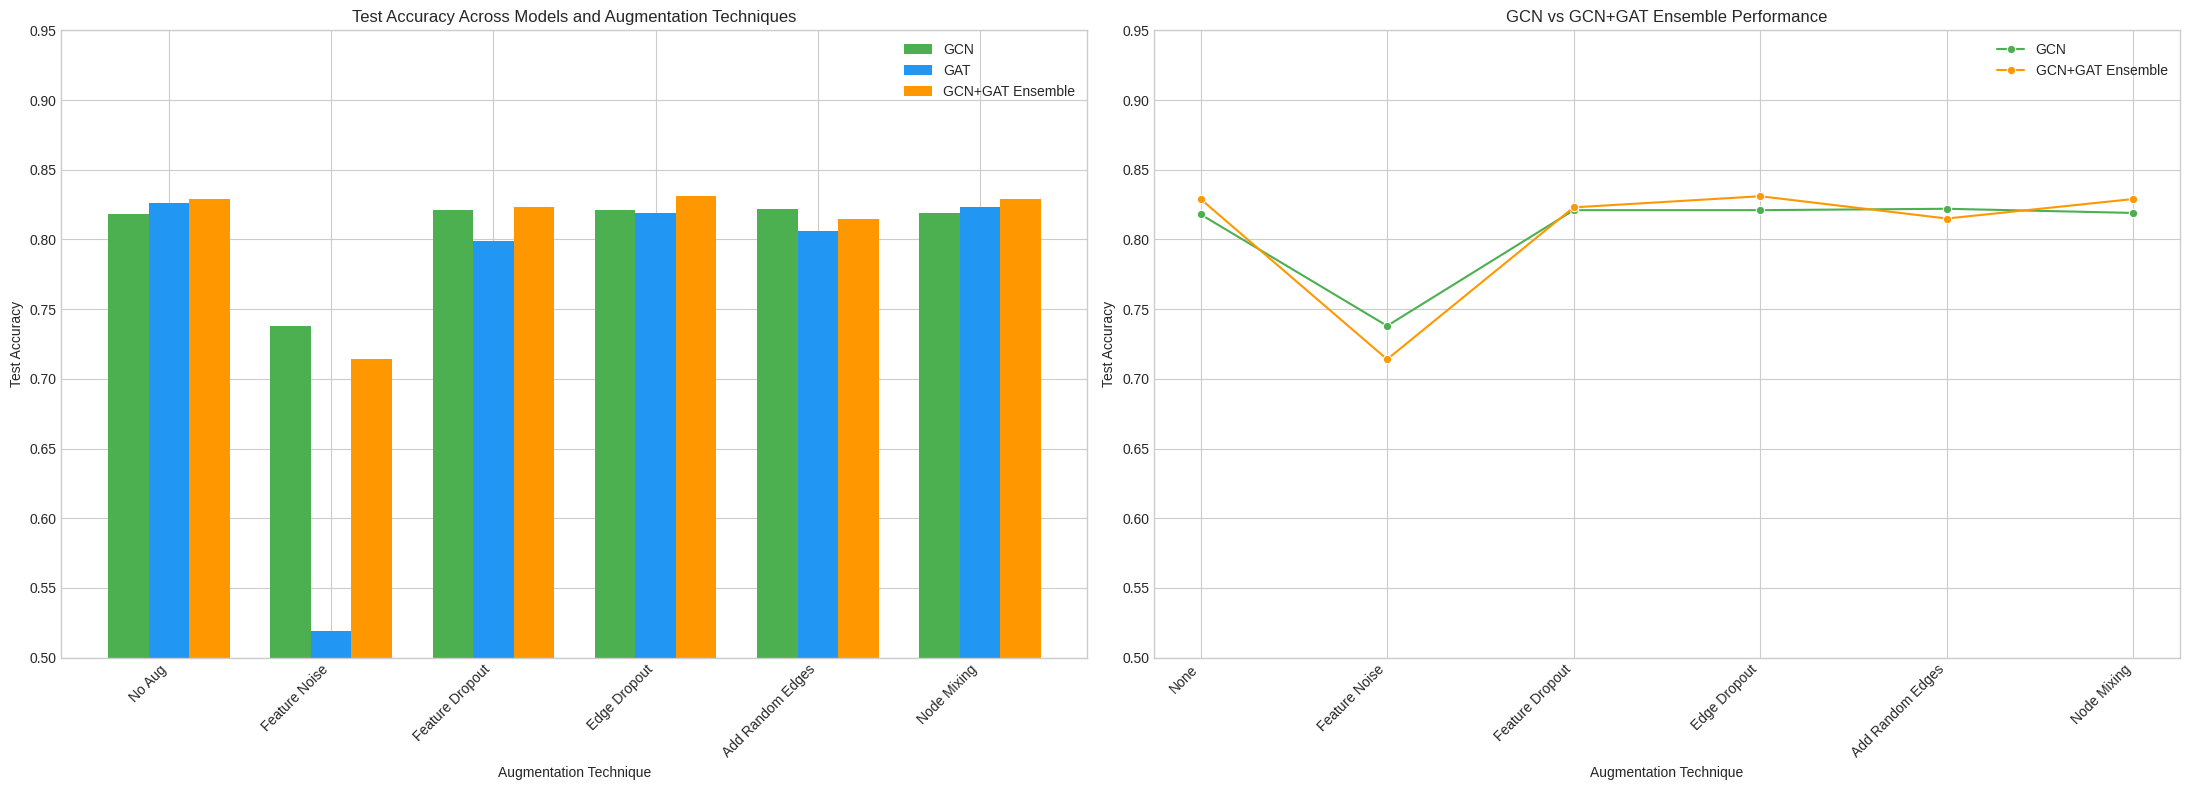

In [ ]:
# --- Final Results Summary and Plotting with Ensembles ---
print("\n\n=== FINAL RESULTS SUMMARY ===")

# Add baseline Logistic Regression at the top
all_results.insert(0, {
    'Model': 'Baseline (LogReg)',
    'Augmentation': 'N/A',
    'Test Accuracy': baseline_acc,
    'Test Macro F1': baseline_f1,
    'Parameters': 'N/A'
})

results_df = pd.DataFrame(all_results)
print(results_df.to_string(index=False))

# --- Plotting ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))

# Prepare DataFrames
gcn_df = results_df[results_df['Model'] == 'GCN'].reset_index(drop=True)
gat_df = results_df[results_df['Model'] == 'GAT'].reset_index(drop=True)
ensemble_df = results_df[results_df['Model'] == 'GCN+GAT Ensemble'].reset_index(drop=True)

x = np.arange(len(gcn_df))
width = 0.25

# Grouped bar chart for GCN vs GAT vs Ensemble
ax1.bar(x - width, gcn_df['Test Accuracy'], width, label='GCN', color='#4CAF50')
ax1.bar(x, gat_df['Test Accuracy'], width, label='GAT', color='#2196F3')
ax1.bar(x + width, ensemble_df['Test Accuracy'], width, label='GCN+GAT Ensemble', color='#FF9800')
ax1.set_xticks(x)
ax1.set_xticklabels(['No Aug'] + list(aug_map.values()), rotation=45, ha='right')
ax1.set_xlabel('Augmentation Technique')
ax1.set_ylabel('Test Accuracy')
ax1.set_title('Test Accuracy Across Models and Augmentation Techniques')
ax1.legend()
ax1.set_ylim(0.5, 0.95)

# Detailed GCN vs Ensemble comparison
gcn_performance = gcn_df[['Augmentation', 'Test Accuracy']].copy()
ensemble_performance = ensemble_df[['Augmentation', 'Test Accuracy']].copy()
gcn_performance.loc[0, 'Augmentation'] = 'None'
ensemble_performance.loc[0, 'Augmentation'] = 'None'

sns.lineplot(x='Augmentation', y='Test Accuracy', data=gcn_performance,
             marker='o', label='GCN', ax=ax2, color='#4CAF50')
sns.lineplot(x='Augmentation', y='Test Accuracy', data=ensemble_performance,
             marker='o', label='GCN+GAT Ensemble', ax=ax2, color='#FF9800')

ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_xlabel('Augmentation Technique')
ax2.set_ylabel('Test Accuracy')
ax2.set_title('GCN vs GCN+GAT Ensemble Performance')
ax2.set_ylim(0.5, 0.95)
ax2.legend()

plt.tight_layout()
plt.show()


## 7. Final Results & Takeaways

In [ ]:
# --- Convert dtypes ---
results_df['Test Accuracy'] = pd.to_numeric(results_df['Test Accuracy'], errors='coerce')
results_df['Test Macro F1'] = pd.to_numeric(results_df['Test Macro F1'], errors='coerce')
results_df['Parameters'] = pd.to_numeric(results_df['Parameters'], errors='coerce')

# --- Baseline ---
baseline_acc = results_df[results_df['Model'] == 'Baseline (LogReg)']['Test Accuracy'].iloc[0]
baseline_f1 = results_df[results_df['Model'] == 'Baseline (LogReg)']['Test Macro F1'].iloc[0]

# --- Base Models (no augmentation) ---
gcn_base = results_df[(results_df['Model'] == 'GCN') & (results_df['Augmentation'] == 'None')].iloc[0]
gat_base = results_df[(results_df['Model'] == 'GAT') & (results_df['Augmentation'] == 'None')].iloc[0]

gcn_base_acc, gcn_base_f1, gcn_params = gcn_base['Test Accuracy'], gcn_base['Test Macro F1'], gcn_base['Parameters']
gat_base_acc, gat_base_f1, gat_params = gat_base['Test Accuracy'], gat_base['Test Macro F1'], gat_base['Parameters']

# --- Best per model family ---
best_gcn = results_df[results_df['Model'] == 'GCN'].sort_values('Test Accuracy', ascending=False).iloc[0]
best_gat = results_df[results_df['Model'] == 'GAT'].sort_values('Test Accuracy', ascending=False).iloc[0]
best_ens = results_df[results_df['Model'] == 'GCN+GAT Ensemble'].sort_values('Test Accuracy', ascending=False).iloc[0]

# --- Global best model ---
best_overall = results_df.sort_values('Test Accuracy', ascending=False).iloc[0]

# --- Improvements ---
gcn_acc_improvement = gcn_base_acc - baseline_acc
gat_acc_improvement = gat_base_acc - baseline_acc
ens_acc_improvement = best_ens['Test Accuracy'] - baseline_acc

print("\n=== Key Findings ===")
print(f"• **GNN models significantly outperform the baseline**. The best GCN reaches {best_gcn['Test Accuracy']:.3f}, "
      f"the best GAT reaches {best_gat['Test Accuracy']:.3f}, and the best Ensemble reaches {best_ens['Test Accuracy']:.3f}, "
      f"compared to the baseline {baseline_acc:.3f}.")
print(f"• Standard GCN improves accuracy by **+{gcn_acc_improvement:.3f}** and Macro F1 by **+{gcn_base_f1 - baseline_f1:.3f}** "
      f"over the baseline. GAT improves by **+{gat_acc_improvement:.3f}** accuracy.")
print(f"• **Best GCN augmentation**: {best_gcn['Augmentation']} "
      f"(Acc={best_gcn['Test Accuracy']:.3f}, F1={best_gcn['Test Macro F1']:.3f})")
print(f"• **Best GAT augmentation**: {best_gat['Augmentation']} "
      f"(Acc={best_gat['Test Accuracy']:.3f}, F1={best_gat['Test Macro F1']:.3f})")
print(f"• **Best Ensemble augmentation**: {best_ens['Augmentation']} "
      f"(Acc={best_ens['Test Accuracy']:.3f}, F1={best_ens['Test Macro F1']:.3f})")
print(f"• **Overall best model**: {best_overall['Model']} with {best_overall['Augmentation']} "
      f"(Acc={best_overall['Test Accuracy']:.3f}, F1={best_overall['Test Macro F1']:.3f})")
print(f"• GCN remains more parameter-efficient with {int(gcn_params)} params vs GAT’s {int(gat_params)}.")

# From here, you can keep your insights, plots, confusion matrix, etc.
# Just replace best_model_name selection with:
best_model_name = best_overall['Model']
best_acc = best_overall['Test Accuracy']



=== Key Findings ===
• **GNN models significantly outperform the baseline**. The best GCN reaches 0.822, the best GAT reaches 0.826, and the best Ensemble reaches 0.831, compared to the baseline 0.473.
• Standard GCN improves accuracy by **+0.345** and Macro F1 by **+0.334** over the baseline. GAT improves by **+0.353** accuracy.
• **Best GCN augmentation**: Add Random Edges (Acc=0.822, F1=0.810)
• **Best GAT augmentation**: None (Acc=0.826, F1=0.816)
• **Best Ensemble augmentation**: Edge Dropout (Acc=0.831, F1=0.817)
• **Overall best model**: GCN+GAT Ensemble with Edge Dropout (Acc=0.831, F1=0.817)
• GCN remains more parameter-efficient with 92231 params vs GAT’s 92373.
